# Machine Learning Programming Exercise 6: <ins>Supervised classification</ins>


## Objectifs


Nous allons dans ce TP classer automatiquement des patchs extraits d'images sonar (cf. figure ci-dessous) en types de fond marin (roches, sables, vases, rides de sable verticales et à 45°, [Posidonie](https://fr.wikipedia.org/wiki/Posidonia_oceanica)).

Quelques exemples de patchs d'image sonar de fond marin:

<img src="https://raw.githubusercontent.com/Teusner/Machine_Learning/master/Seabed_Classification/dataset/patch.png" />


L'objectif est d'écrire des scripts permettant de mettre en \oe uvre un système basé sur différentes approches supervisées de machine learning. Ces scripts devront ainsi suivre la chaîne générale décrite en cours (à l'exception de la phase de captation; cf. figure ci-dessous ) :
* prétraitements
* extraction des descripteurs
* apprentissage d'un modèle de classement
* classement des pixels
* évaluation du classifieur appris

<img src="https://raw.githubusercontent.com/Teusner/Machine_Learning/master/Seabed_Classification/dataset/imgs/Ripple vertical_Sure.00015.png" />

Le TP est globalement organisé de la manière suivante
* **Données**
 1. tout d'abord apprendre les modèles de classement (classifieurs) sur les données brutes (descripteurs=features=valeurs des pixels) 
 2. puis dans un second temps sur des descripteurs extraits à partir d'un algorithme appelé [scattering operator](https://www.di.ens.fr/data/scattering) (le fonctionnement exact n'est pas au programme mais il s'apparente à une banque de filtres mise en cascade). 

* **Prétraitements** Aucun prétraitement ne sera réalisé. 

* **Ensembles de données**
 1. Les ensembles de données seront composés de 1/3 de la base totale d'images. 
 2. Dans un second temps, nous procéderons par [validation croisée](https://scikit-learn.org/stable/modules/cross_validation.html) car la base d'images est de taille réduite.
* **Algorithmes** 
    Concernant les algorithmes supervisés de machine learning, l'objectif est d'utiliser les deux algorithmes de regression logistique et de réseaux de neurones que vous avez développés aux TP précédents et de découvrir le package python [scikit-learn](http://scikit-learn.org/stable/user_guide.html) qui vous permettra d'utiliser les algorithmes de [régression logistique](https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression), [réseaux de neurones](https://scikit-learn.org/stable/modules/neural_networks_supervised.html), [random forests](https://scikit-learn.org/stable/modules/ensemble.html#forest) et [svm](https://scikit-learn.org/stable/modules/svm.html#svm-classification).

* Pour commencer avec cette séance, vous aurez besoin de **télécharger** le _starter code_  disponible sur le lien Moodle du cours.

<span style='color:red'>**Dans cet exercice, il vous est demandé de fournir un rapport regroupant les réponses aux questions, vos analyses et vos codes. Ce rapport pourra prendre la forme d'un pdf ou d'un jupyter notebook. Il est de plus conseillé de faire tourner les codes sur google colab si votre machine manque de puissance (dans ce cas un jupyter notebook est nécessaire).**</span>


## Fichiers inclus dans le starter code pour cette séance
* **pythonTools.py** - fonctions utiles pour l'affichage, le chargement des données et l'évaluation des performances
* **usefulCmds.py** - quelques commandes pour faciliter l'import des patchs
* **dataSet** - répertoire avec les images et les labels correspondants
* **dataSet\imdb_200x200_SmallSonarTex_db_6classes_scatValOnly.mat** - fichier matlab contenant les descripteurs extraits des images par le scattering operator



# Part 0: intro

## 0.1 imports

First we need to import some usefull libraries in order to classify these seafloor sonar images.

In [1]:
# Dealing with system module and the current working directory
import sys
import os

# Data manipulation libraries
import numpy as np
import pandas as pd

# Scikit image manipulating and preprocessing functions to label our data
import skimage
from sklearn import preprocessing

# Function used to optimize the cost function
from scipy.optimize import fmin_tnc, fmin_cg, fmin_l_bfgs_b

Then we need to mount our working directory in order to get our dataset. Moreover we have to load some tools out of the _pythonTools_ module also available on my google drive.

In [2]:
# Testing if we are in google colab
IN_COLAB ='google.colab' in sys.modules

if IN_COLAB:
  # Mounting our drive folder
  from google.colab import drive
  drive.mount('/content/gdrive', force_remount=True)

  # Changing the current working directory
  os.chdir("/content/gdrive/My Drive/Machine_Learning")
  
  # Importing a module from our drive folder
  from pythonTools import *

Mounted at /content/gdrive
None


## 0.2 Data analysing

This subsection is about the loading and the analyse of our dataset. The following tasks will be done :
* Loading the dataset available in _labels.csv_,
* Build a matrix containing the features of the images dataset
* Show a patch of data using _plot\_batch()_ available in _pythonTools.py_,

### 0.2.1 Dataset loading

To load the dataset, we first need to specify the path to the csv file which lists the different images and their labels. Then we are able to load this file in a _pandas_ dataframe named dataset_df.

In [3]:
# Loading the csv file
DATASET_PATH = r'./dataset/imgs/'
LABEL_PATH = r'./dataset/labels/labels.csv'
dataset_df = pd.read_csv(LABEL_PATH)

# We add another column to the labels dataset to identify image path
dataset_df['image_path'] = dataset_df.apply( lambda row: (DATASET_PATH + row["id"] ), axis=1)

**Question: What is the number of data, the number of features**

In [4]:
print(dataset_df)

                                 id  ...                                     image_path
0          Posidonia_Sure.00001.png  ...        ./dataset/imgs/Posidonia_Sure.00001.png
1          Posidonia_Sure.00002.png  ...        ./dataset/imgs/Posidonia_Sure.00002.png
2          Posidonia_Sure.00008.png  ...        ./dataset/imgs/Posidonia_Sure.00008.png
3          Posidonia_Sure.00011.png  ...        ./dataset/imgs/Posidonia_Sure.00011.png
4          Posidonia_Sure.00029.png  ...        ./dataset/imgs/Posidonia_Sure.00029.png
..                              ...  ...                                            ...
355  Ripple vertical_Sure.00562.png  ...  ./dataset/imgs/Ripple vertical_Sure.00562.png
356  Ripple vertical_Sure.00564.png  ...  ./dataset/imgs/Ripple vertical_Sure.00564.png
357  Ripple vertical_Sure.00669.png  ...  ./dataset/imgs/Ripple vertical_Sure.00669.png
358  Ripple vertical_Sure.00843.png  ...  ./dataset/imgs/Ripple vertical_Sure.00843.png
359  Ripple vertical_Sure.00855.

There is 360 different data in the provided database. We could also see that for each data there is an entry in this database to get the unique id of the data, and the path to the correspondig image.

In [5]:
n = 3
sample = dataset_df.sample(n)
sample_array = np.array([plt.imread(img) for img in sample['image_path'].values.tolist()])
for i in range(n):
  m, n = sample_array[i].shape[0], sample_array[i].shape[1]
  print("Image {0:<5} {1:<30} : size {2}x{3} ↦ {4} features".format(i+1, sample.iloc[i]["id"], m, n, m*n))

Image 1     Ripple vertical_Sure.00202.png : size 200x200 ↦ 40000 features
Image 2     Posidonia_Sure.00134.png       : size 200x200 ↦ 40000 features
Image 3     Ripple vertical_Sure.00201.png : size 200x200 ↦ 40000 features


We could see that each random picture out of this dataset is a 200x200 pixels sonar image, what makes 40 000 features for each data.

### 0.2.2 Shaping the dataset matrix

We need to load our data in a matrix in order to use it to train our model. Let's introduce the matrix X which will pack the dataset as follows :

$$
X = 
  \begin{bmatrix}
    X_1.T \\
    \vdots \\
    X_n.T
  \end{bmatrix}
$$

Where $X_1 \dots X_n$ are the column vector associated to each data in our dataset which represents the different features for each data. Each column vector has also a shape of (40000, 1) and the $X$ matrix has a shape of (360, 40000).

In [6]:
# Loading the dataset in the X matrix
X = np.array([plt.imread(img).reshape(40000,) for img in dataset_df['image_path'].values.tolist()])

Then we need to get every unique labels out of our dataset. It will be usefull for our learning and our classification.

In [7]:
# Getting labels
label_names = dataset_df['seafloor']
label_names_unique = label_names.unique()

### 0.2.3 Dataset visualization

The following subsubsection is about data visualization. It's helpful to see a patch of random data out of our dataset. It let us check manually a subpart of the dataset, and to be able to check by hand the different classes available.

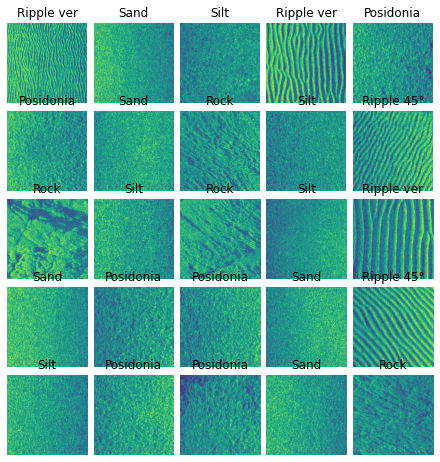

In [8]:
# Getting 25 random data in our dataset
batch = load_batch(dataset_df)
# Showing a patch of these data
plot_batch(batch, 5, 5, 1, 1)

## 0.3 prétraitements des labels

Écrire des lignes de code, un script ou une fonction _preprocessing()_ permettant:
* de disposer des labels dans différents [codages](https://scikit-learn.org/stable/modules/preprocessing_targets.html) (noms, indices, one-hot-encoding, etc.) 


_Your commented code below_

In [9]:
# Labels encoding by index
le = preprocessing.LabelEncoder()
le.fit(label_names_unique)
label_indices = le.transform(label_names_unique)

# Labels one-hot-encoding
label_ohe = pd.get_dummies(label_names.reset_index(drop=True)).values

# Getting labels for our dataset
y = le.transform(label_names)

## 0.4 Séparation des données en ensembles 

Écrire des lignes de code, un script ou une fonction _preprocessing()_ permettant:
* de [normaliser](https://scikit-learn.org/stable/modules/preprocessing.html) les données si besoin 
* de [créer deux ensembles](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html#sklearn.model_selection.train_test_split) un pour l'apprentissage et un pour le test


_Your commented code below_

In [10]:
# Separating our data in a training dataset and a testing dataset with a 1/3 ratio
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [11]:
# Creating a StandardScaler()
scaler = preprocessing.StandardScaler()

# Getting statistical indicators from the dataset and normalizing training and testing data
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

<strong>Question: Quel est le nombre de données totales et <ins>pour chaque classe</ins>, le nombres de descripteurs pour <ins>chaque ensemble de données</ins></strong>

In [12]:
def print_dataset_stats(title, y):
  print("{} ({:3} data) :".format(title, y.shape[0]))
  unique, counts = np.unique(le.inverse_transform(y), return_counts=True)
  for i, label in zip(counts, unique):
    print("  ➤ {:2} {}".format(i, label))
  print("")

print_dataset_stats("Training data", y_train)
print_dataset_stats("Testing data", y_test)

Training data (241 data) :
  ➤ 39 Posidonia
  ➤ 36 Ripple 45°
  ➤ 39 Ripple vertical
  ➤ 43 Rock
  ➤ 38 Sand
  ➤ 46 Silt

Testing data (119 data) :
  ➤ 21 Posidonia
  ➤ 24 Ripple 45°
  ➤ 21 Ripple vertical
  ➤ 17 Rock
  ➤ 22 Sand
  ➤ 14 Silt



Our 360 input data are divided in 241 training data and 119 testing data, with the provided ratio of $\frac{1}{3}$. Then for each class, the previous cell shows us the number of class available for each dataset. Each data provide of course 40 000 features.

# Part 1 approches supervisées sur données brutes

<strong><ins>Question</ins>: Y-a-t-il besoin de normaliser les descripteurs? Si oui, que faut-il conserver comme information et pourquoi?</strong> 

The standardization of descriptors is an important step in machine learning. Indeed, descriptors need to have a mean of 0 and a standard deviation of 1 in order to use most algorithms. We then just need to keep the mean and standard deviations of the training data that we will have used during the training phase, in order to be able to normalize the new data afterwards and thus make a prediction on this new data.

**<ins>Question</ins>: Nous allons apprendre les modèles suivants:
* régression logistique régularisée et réseaux de neurones développés dans les tps précédents,
* régression logistique, réseaux de neurones (solver=lbfgs), svm et random forest en utilisant les fonctions du package scikit-learn

Faire la liste des hyper-paramètres (paramètre uniquement lié à l'algorithme d'apprentissage) de chaque algorithme. Comment fixe-t-on leurs valeurs?**

_votre réponse ici:_ 

<strong><ins>Question</ins>: Fixez au mieux les valeurs des hyperparamètres, réalisez l'apprentissage des modèles suivants: 
* régression logistique régularisée et réseaux de neurones développés dans les tps précédents,
* régression logistique, réseaux de neurones, svm et random forest en utilisant les fonctions du package scikit-learn
</strong>

_Your code below_

## 1.1 Logistic Regression and neural network

Let's introduce a simple neural network based on an input layer which will take the 40 000 features, a hidden layer which will transform these inputs into 15 intermediates layers, and an output layer which will give the 6 different outputs of our problem.

We will need an activation function which transform the output of a perceptron into a probability in [0, 1]. Then, by differentiation of the sigmoid function, we are able to calculate the gradient of the sigmoid, which will allow us to adjust the neural network coefficients.

In [13]:
def sigmoid(z):
    """computes the sigmoid of z."""
    return  1 / (1 + np.exp(-z))

def sigmoidGradient(z):
    """computes the gradient of the sigmoid function
    evaluated at z. This should work regardless if z is a matrix or a
    vector. In particular, if z is a vector or matrix, you should return
    the gradient for each element."""
    g = sigmoid(z) * (np.ones((sigmoid(z)).shape) - sigmoid(z))
    return g

We need to have a function to randomly initialize the weights of our model. If these values are not initialized correctly, we could miss the minimum of the cost function. One effective strategy for random initialization is to randomly select values for $\Theta^{(l)}$ uniformly in the range $[− \epsilon_{init} ;  \epsilon_{init}]$. $\epsilon_{init}$ is choosen so that $\epsilon_{init} = \frac{\sqrt{6}}{\sqrt{L_{in} + L_{out}}}$. This range of values ensures that the parameters are kept small and makes the learning more efficient.

In [14]:
def randInitializeWeights(L_in, L_out):
    """randomly initializes the weights of a layer with L_in incoming connections and L_out outgoing
      connections.

      Note that W should be set to a matrix of size(L_out, 1 + L_in) as the column row of W handles the "bias" terms
    """
    epsilon_init = np.sqrt(6) / np.sqrt(L_in + L_out)
    return np.random.rand(L_out, 1+L_in) * 2 * epsilon_init - epsilon_init

In [15]:
def nnCostFunction(nn_params, input_layer_size, hidden_layer_size, num_labels, X, y, Lambda):
    """computes the cost and gradient of the neural network. The
    parameters for the neural network are "unrolled" into the vector
    nn_params and need to be converted back into the weight matrices.

    The returned parameter grad should be a "unrolled" vector of the
    partial derivatives of the neural network.
    """

    # Get theta1 and theta2 back from nn_params
    theta1 = nn_params[0:(hidden_layer_size*(input_layer_size+1))].reshape((input_layer_size+1),hidden_layer_size).T
    theta2 = nn_params[(hidden_layer_size*(input_layer_size+1)):].reshape((hidden_layer_size+1),num_labels).T

    # Get the shape of X
    m, _ = X.shape

    # You need to return the following variables correctly 
    J = 0
    theta1_grad = np.zeros(theta1.shape)
    theta2_grad = np.zeros(theta2.shape)

    # One hot encoding of the waited output
    y_matrix = (np.arange(0, y.max()+1) == y.flatten()[:,None]).astype(int).T
    
    # Compute Cost
    ## Input Layer
    a1 = np.hstack((np.ones((m, 1)), X)).T
    ## Hidden Layer
    z2 = theta1@a1
    a2 = np.vstack((np.ones((1, m)), sigmoid(z2)))
    ## Output Layer
    z3 = theta2@a2
    a3 = sigmoid(z3)
    
    # Ragularized cost computing
    inner = - y_matrix.T * np.log(a3).T - (np.ones(y_matrix.shape) - y_matrix).T * np.log(np.ones((a3).shape) - a3).T
    J = np.sum(inner) / m + (Lambda/(2*m))*(np.sum(np.square(theta1[:,1:])) + np.sum(np.square(theta2[:,1:])))
    
    # Gradients
    d3 = a3 - y_matrix
    d2 =  (theta2[:,1:].T@d3) * sigmoidGradient(z2)
    
    delta1 = d2.dot(a1.T)
    delta2 = d3@(a2.T)
    
    # Gradient regularisation
    theta1_grad = delta1/m  
    reg = (theta1_grad[:,1:]*Lambda)/m
    theta1_grad[:,1:] = theta1_grad[:,1:] + reg 
    
    theta2_grad = delta2/m  
    reg = (theta2[:,1:]*Lambda)/m
    theta2_grad[:,1:] = theta2_grad[:,1:] + reg

    # Unroll gradient
    grad = np.hstack((theta1_grad.T.ravel(), theta2_grad.T.ravel()))

    return J, grad

In [16]:
# Setup the layer size of our model
input_layer_size = 200*200  # 200x200 input sonar images
hidden_layer_size = 15      # 400 hidden units
num_labels = 6              # 6 output labels

In [17]:
# Initialise our parameters with random values
initial_theta1 = randInitializeWeights(input_layer_size, hidden_layer_size)
initial_theta2 = randInitializeWeights(hidden_layer_size, num_labels)

# Unroll parameters
initial_nn_params = np.hstack((initial_theta1.T.ravel(), initial_theta2.T.ravel()))

In [18]:
Lambda = 5

costFunc = lambda p: nnCostFunction(p, input_layer_size, hidden_layer_size, num_labels, X_train, y_train, Lambda)[0]
gradFunc = lambda p: nnCostFunction(p, input_layer_size, hidden_layer_size, num_labels, X_train, y_train, Lambda)[1]

result = fmin_l_bfgs_b(costFunc, x0=initial_nn_params, fprime=gradFunc, maxfun=15000, maxiter=15000)
#result = fmin_tnc(costFunc, fprime=gradFunc, x0=initial_nn_params, disp=True)
#result = fmin_cg(costFunc, fprime=gradFunc, x0=initial_nn_params, maxiter=100, disp=True, full_output=True)
nn_params = result[0]
cost = result[1]

In [19]:
# Obtain theta1 and theta2 back from nn_params
theta1 = nn_params[0:(hidden_layer_size*(input_layer_size+1))].reshape((input_layer_size+1),hidden_layer_size).T
theta2 = nn_params[(hidden_layer_size*(input_layer_size+1)):].reshape((hidden_layer_size+1),num_labels).T

**<ins>Question</ins>: Évaluer les modèles appris en décrivant votre méthode**

_votre réponse ici:_

_Your code below_

In [20]:
def predictNeuralNetwork(Theta1, Theta2, X):
  """ outputs the predicted label of X given the
  trained weights of a neural network (Theta1, Theta2)
  """
  m, _ = X.shape
  num_labels, _ = Theta2.shape
  probas = sigmoid(Theta2 @ (np.vstack((np.ones((1, m)), sigmoid(Theta1 @ X.T)))))
  p = np.argmax(probas, axis=0).reshape((m, 1))
  return p.flatten()

In [21]:
m, _ = X_test.shape
Xp = np.column_stack((np.ones((m, 1)), X_test))

y_pred = predictNeuralNetwork(theta1, theta2, Xp)

accuracy = np.mean(np.double(y_pred == y_test.flatten())) * 100
print('Training Set Accuracy: %f\n'% accuracy)

Training Set Accuracy: 42.857143



Normalized confusion matrix
[[0.14285714 0.19047619 0.04761905 0.         0.19047619 0.42857143]
 [0.04166667 0.33333333 0.08333333 0.         0.29166667 0.25      ]
 [0.0952381  0.0952381  0.28571429 0.04761905 0.19047619 0.28571429]
 [0.17647059 0.         0.         0.05882353 0.05882353 0.70588235]
 [0.         0.04545455 0.         0.         0.95454545 0.        ]
 [0.14285714 0.         0.         0.         0.         0.85714286]]


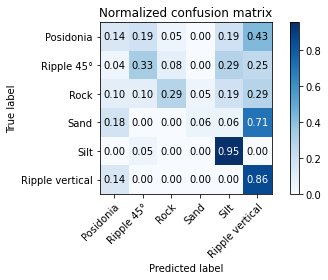

In [22]:
plot_confusion_matrix(y_test, y_pred, label_names_unique, normalize=True, title=None, cmap=plt.cm.Blues)

In [23]:
# Getting the labels and the predicted labels
true_labels = le.inverse_transform(y_test)
predicted_labels = le.inverse_transform(y_pred)

# Getting metrics on the prediction
get_metrics(true_labels, predicted_labels)

Accuracy: 0.4286
Precision: 0.4811
Recall: 0.4286
F1 Score: 0.3809


**<ins>Question</ins>: Réalisez un diagramme fonctionnel décrivant le flux des données tout au long de l'approche supervisée. Ce diagramme devra faire apparaître au minimum: les trois ensembles d'images, les descripteurs, les différents algorithmes d'apprentissage, l'évaluation (mettre une image dans le répertoire courant et dans la cellule ci-dessous remplacer par le nom du fichier)**

_Your image here_ <img src="https://github.com/Teusner/Machine_Learning/blob/master/Seabed_Classification/fichierDiagramme.png?raw=1" />

# Partie 2: Approche supervisée sur descripteurs issus du scattering operator

## Chargement des descripteurs

**<ins>Question</ins>: Chargez les données du fichier matlab imdb_200x200_SmallSonarTex_db_6classes_scatValOnly.mat**

_Your Code below_

In [24]:
from scipy.io import loadmat

In [48]:
# Loading the csv file
DATASET_PATH = r'./dataset/'
DATASET_FILE = r'./imdb_200x200_SmallSonarTex_db_6classes_scatValOnly.mat'
DATASET = os.path.join(DATASET_PATH, DATASET_FILE)

# Loading the dataset
data_mat = loadmat(DATASET)

In [49]:
# Shaping our X vector
X = np.array([img.reshape(217,) for img in data_mat["featVal"]])

In [50]:
# Loading the csv file
DATASET_PATH = r'./dataset/imgs/'
LABEL_PATH = r'./dataset/labels/labels.csv'
dataset_df = pd.read_csv(LABEL_PATH)

In [51]:
# Getting labels
label_names = dataset_df['seafloor']
label_names_unique = label_names.unique()

## Prétraitements

**<ins>Question</ins>: Y-a-t-il besoin de normaliser les descripteurs? Si oui, que faut-il conserver comme information et pourquoi?**

_votre réponse ici:_ 

_Your Code below_

## Apprentissage

<strong><ins>Question</ins>: Séparer en deux ensembles de données et réalisez l'apprentissage successifs des modèles:
* régression logistique, réseaux de neurones, svm et random forest en utilisant les fonctions du package scikit-learn
</strong>

<span style='color:red'> **Pas de code à développer ici, réutiliser celui de la partie 1**</span>

_Your Code below_

## Fixer les hyper paramètres

**<ins>Question</ins>: Déterminez les hyper-paramètres (paramètre uniquement lié à l'algorithme d'apprentissage) de chaque algorithme. Comment allez vous les fixer?**

_votre réponse ici:_

**<ins>Question</ins>:
Lisez le [tutoriel suivant](https://scikit-learn.org/stable/auto_examples/applications/plot_face_recognition.html\#sphx-glr-auto-examples-applications-plot-face-recognition-py) en faisant particulièrement attention à la façon dont est gérée la détermination des hyperparamètres et l'évaluation des performances. Reproduisez cette méthodologie en testant différents nombres de plis (fold).**

_Your Code below_

**<ins>Question</ins>: Évaluer les résultats et donner la valeur des paramètres optimaux**

_votre réponse ici:_

_Your Code below_

## Apprendre le modèle final pour chaque classifieur

_votre réponse ici:_

_Your Code below_

## Evaluer chaque classifieur

_votre réponse ici:_ 

_Your Code below_

## Partie 4 Analyse finale des résultats


**<ins>Question</ins>: Réalisez un diagramme fonctionnel décrivant le flux des données tout au long de l'approche supervisée. Ce diagramme devra faire apparaître au minimum: les trois ensembles d'images, les descripteurs, les différents algorithmes d'apprentissage, l'évaluation, les différents blocs de traitements.**

_votre réponse ici:_ 

_Your Code below_

**<ins>Question</ins>: Faites une synthèse des résultats obtenus. Dresser en particulier des conclusions en fonction des descripteurs utilisés, des algorithmes utilisés et des prétraitements effectués.**

_votre réponse ici:_